In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

import otaf

# Testing the imprecise modelization for different feature types. 

- The goal is to know if the modelization using the normalized $\Lambda$ space to drive the defects truely works, i.e. the probability to be outside of the space of validity remain constant.
- We'll model all the basic surfaces / defect types in 2D and 3D

The approach we'll follow is :
- Choose a feature type with a specific tolerance applied to it.
- Dimension the distributions of the defect for each degree of freedom inidivudally using the 6 sigma method.
- Generate a low discrepancy sequence, with lots of points to get convergence, for each degree of freedom.
- Construct a function to check which point of the sample are within the tolerance zone
- Sample the space of imprecision (not that easy)
- Do the double monte carlo and check the dispersion of the probabilities of being out of the space

# Example demonstration.
To get a better understanding of the approach, here is the detailed way of doing for a basic feature and tolerance zone. 
A line that has a localization tolerance $t$ applied to it, has  a tolerance zone that is a 2D rectangle. The deviated line has to exist within it to be valid. The tolerance is centered. Only rigid (SDOF approach) defects are modelled, so one translation and one rotation. 
The line is of length L.

In [2]:
C=1
t = 1
L = 100
N = int(1e6)

sigma_u_max = t/(C*6)

gamma_max = t/L
sigma_gamma_max = (2*gamma_max)/(C*6)

In [3]:
# This is from the new develoment for the link between distribution parameters.
Pf_target = 0.00265
t**2 / (8*sp.special.erfinv(1-Pf_target))
np.sqrt(0.05881448627989255)

np.float64(0.24251698142582212)

In [20]:
# Sample theta from uniform distribution in [0, pi/2]
theta_samples = np.linspace(0, np.pi/2, 100)

# Compute lambda_u and lambda_gamma
lambda_u_samples = np.cos(theta_samples)
lambda_gamma_samples = np.sin(theta_samples)

In [21]:
lambda_u_samples

array([1.00000000e+00, 9.99874128e-01, 9.99496542e-01, 9.98867339e-01,
       9.97986676e-01, 9.96854776e-01, 9.95471923e-01, 9.93838464e-01,
       9.91954813e-01, 9.89821442e-01, 9.87438889e-01, 9.84807753e-01,
       9.81928697e-01, 9.78802446e-01, 9.75429787e-01, 9.71811568e-01,
       9.67948701e-01, 9.63842159e-01, 9.59492974e-01, 9.54902241e-01,
       9.50071118e-01, 9.45000819e-01, 9.39692621e-01, 9.34147860e-01,
       9.28367933e-01, 9.22354294e-01, 9.16108457e-01, 9.09631995e-01,
       9.02926538e-01, 8.95993774e-01, 8.88835449e-01, 8.81453363e-01,
       8.73849377e-01, 8.66025404e-01, 8.57983413e-01, 8.49725430e-01,
       8.41253533e-01, 8.32569855e-01, 8.23676581e-01, 8.14575952e-01,
       8.05270258e-01, 7.95761841e-01, 7.86053095e-01, 7.76146464e-01,
       7.66044443e-01, 7.55749574e-01, 7.45264450e-01, 7.34591709e-01,
       7.23734038e-01, 7.12694171e-01, 7.01474888e-01, 6.90079011e-01,
       6.78509412e-01, 6.66769001e-01, 6.54860734e-01, 6.42787610e-01,
      

In [22]:
sample_u = np.random.normal(0, sigma_u_max, (N,))
sample_gamma = np.random.normal(0, sigma_gamma_max, (N,))

# easy here, there are two lambdas with lambda1 + lambda2 = 1 
lambda_sample = np.linspace(0,1,100)

def deviation_domain_line2D(sample_u, sample_gamma, t=t, L=L):
    """
    Optimized function that returns a boolean array indicating 
    whether the points are within the deviation domain (True) or not (False).
    """
    # Initialize output array directly as a boolean array (True by default)
    output_arr = np.ones(sample_u.shape, dtype=bool)
    
    # Apply the conditions in a vectorized manner
    # Check if u is out of bounds
    output_arr &= (sample_u >= -t/2) & (sample_u <= t/2)
    
    # Check if gamma is within the tolerance boundaries
    output_arr &= (sample_gamma >= -t/L) & (sample_gamma <= t/L)
    
    # Compute the final condition (combined) and apply it
    condition = np.abs(sample_u) + np.abs((sample_gamma*L) / (2))
    output_arr &= (condition >= 0) & (condition <= t/2)
    
    return output_arr.astype(int)  # Return as 0/1 integer array as per original


probabilities_out_dd = [1-deviation_domain_line2D(np.sqrt(lambda_)*sample_u, np.sqrt(1-lambda_)*sample_gamma).mean() for lambda_ in lambda_sample]
 
#probabilities_out_dd = Parallel(n_jobs=-1)(
#    delayed(lambda lambda_: 1 - deviation_domain_line2D(np.power(lambda_, 1/2) * sample_u, np.power(1 - lambda_, 1/2) * sample_gamma).mean())(lambda_) 
#    for lambda_ in lambda_sample
#)
#probabilities_out_dd = Parallel(n_jobs=-1)(
#    delayed(lambda u,g: 1 - deviation_domain_line2D(u * sample_u, g * sample_gamma).mean())(u,g) 
#    for u,g  in zip(lambda_u_samples, lambda_gamma_samples)
#)

In [23]:
#%matplotlib qt

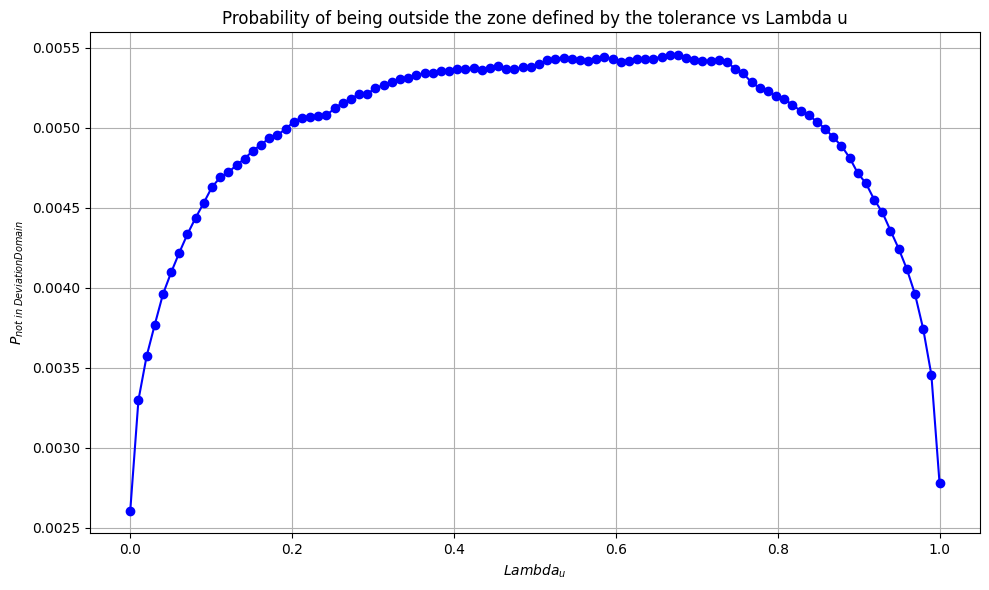

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_sample, probabilities_out_dd, color='blue', marker='o', linestyle='-')
plt.xlabel('$Lambda_u$')
plt.ylabel('$P_{not\ in\ Deviation Domain}$')
plt.title('Probability of being outside the zone defined by the tolerance vs Lambda u')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [25]:
def deviation_domain_line2D(sample_u, sample_gamma, t=t, L=L):
    """
    Function that returns a boolean array indicating 
    whether the points are within the deviation domain (True/False) 
    and the distribution of maximum distances from the nominal position.
    
    Returns:
    - Boolean array (True/False) for points inside the deviation domain.
    - Array of maximum distances from the nominal position.
    """
    # Initialize output array directly as a boolean array (True by default)
    output_arr = np.ones(sample_u.shape, dtype=bool)
    
    # Apply the conditions in a vectorized manner
    # Check if u is out of bounds
    output_arr &= (sample_u >= -t/2) & (sample_u <= t/2)
    
    # Check if gamma is within the tolerance boundaries
    output_arr &= (sample_gamma >= -t/L) & (sample_gamma <= t/L)
    
    # Compute the final condition (combined) and apply it
    condition = np.abs(sample_u) + np.abs((sample_gamma * L) / 2)
    output_arr &= (condition >= 0) & (condition <= t/2)
    
    # Compute the maximum distance from the nominal position
    dist_top = sample_u+sample_gamma*L/2
    dist_bot = sample_u-sample_gamma*L/2
    max_distance = np.where(np.abs(dist_top)>=np.abs(dist_bot), dist_top, dist_bot)
    
    return output_arr.astype(int), max_distance  # Return as a 0/1 array and distances

# Now you can compute both the deviation domain and distances
# Let's calculate probabilities_out_dd, mean, and std deviation of the distances

#results = Parallel(n_jobs=-1)(
#    delayed(lambda lambda_: deviation_domain_line2D(np.sqrt(lambda_) * sample_u, np.sqrt(1 - lambda_) * sample_gamma))(lambda_) 
#    for lambda_ in lambda_sample
#)
results = Parallel(n_jobs=2)(
    delayed(lambda u,g: deviation_domain_line2D(u * sample_u, g * sample_gamma))(u,g) 
    for u,g  in zip(lambda_u_samples, lambda_gamma_samples)
)

# Separate the boolean arrays and distances
in_domain, distances = zip(*results)

# Calculate the probabilities of being outside the domain
probabilities_out_dd = [1 - np.mean(domain) for domain in in_domain]

# Calculate the mean and standard deviation of the distances for each lambda
mean_distances = [np.mean(dist) for dist in distances]
std_distances = [np.std(dist) for dist in distances]

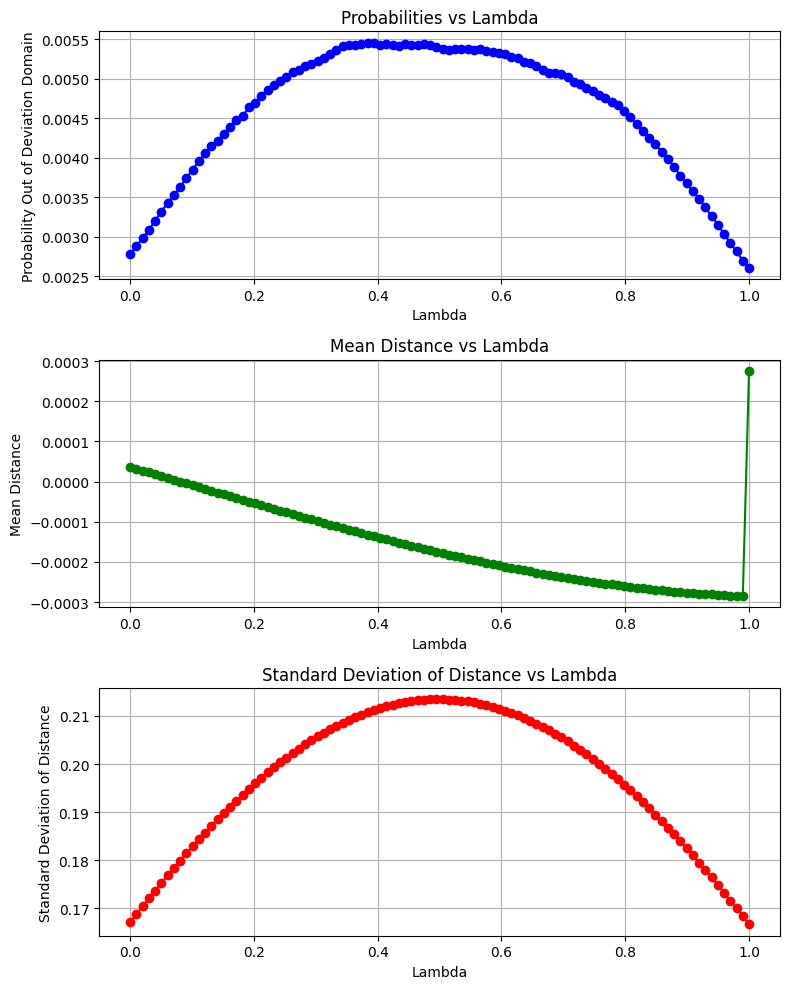

In [26]:
plt.figure(figsize=(8, 10))

# First subplot: probabilities_out_dd vs lambda_sample
plt.subplot(3, 1, 1)
plt.plot(lambda_sample, probabilities_out_dd, color='blue', marker='o', linestyle='-')
plt.xlabel('Lambda')
plt.ylabel('Probability Out of Deviation Domain')
plt.title('Probabilities vs Lambda')
plt.grid(True)

# Second subplot: mean_distances vs lambda_sample
plt.subplot(3, 1, 2)
plt.plot(lambda_sample, mean_distances, color='green', marker='o', linestyle='-')
plt.xlabel('Lambda')
plt.ylabel('Mean Distance')
plt.title('Mean Distance vs Lambda')
plt.grid(True)

# Third subplot: std_distances vs lambda_sample
plt.subplot(3, 1, 3)
plt.plot(lambda_sample, std_distances, color='red', marker='o', linestyle='-')
plt.xlabel('Lambda')
plt.ylabel('Standard Deviation of Distance')
plt.title('Standard Deviation of Distance vs Lambda')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [27]:
pcs = [otaf.capabilities.process_capability(t/2, -t/2, mean, std) for mean,std in zip(mean_distances, std_distances)]

In [28]:
# Assuming pcs is a list of dictionaries, and lambda_sample is already defined
Cp_values = [pc['Cp'] for pc in pcs]
CPU_values = [pc['CPU'] for pc in pcs]
CPL_values = [pc['CPL'] for pc in pcs]
Cpk_values = [pc['Cpk'] for pc in pcs]
k_values = [pc['k'] for pc in pcs]

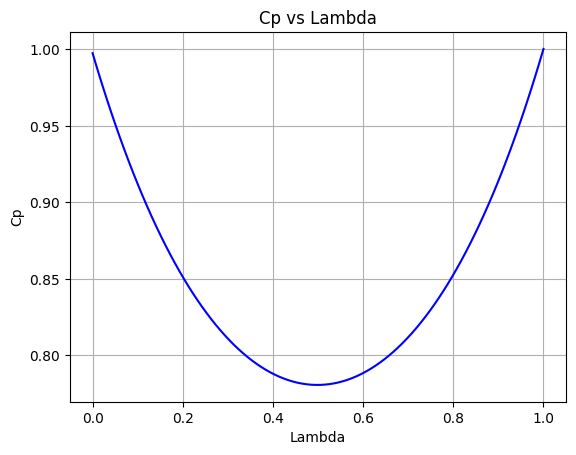

In [29]:
plt.figure()
plt.plot(lambda_sample, Cp_values, label='Cp', color='blue')
plt.xlabel('Lambda')
plt.ylabel('Cp')
plt.title('Cp vs Lambda')
plt.grid(True)
plt.show()

In [37]:
#STOP

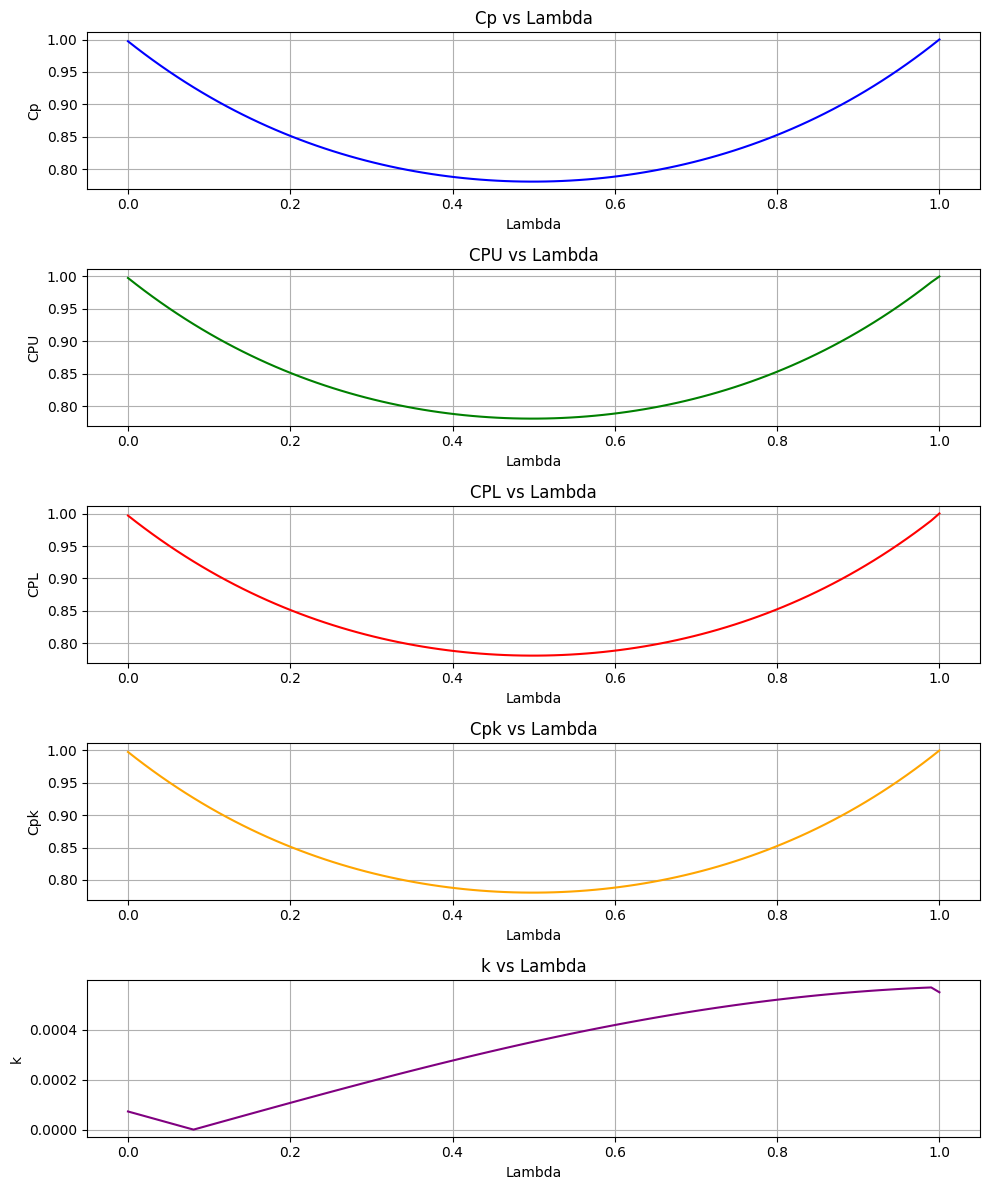

In [31]:
# Create individual plots for each of the indices
plt.figure(figsize=(10, 12))

# Plot Cp
plt.subplot(5, 1, 1)
plt.plot(lambda_sample, Cp_values, label='Cp', color='blue')
plt.xlabel('Lambda')
plt.ylabel('Cp')
plt.title('Cp vs Lambda')
plt.grid(True)

# Plot CPU
plt.subplot(5, 1, 2)
plt.plot(lambda_sample, CPU_values, label='CPU', color='green')
plt.xlabel('Lambda')
plt.ylabel('CPU')
plt.title('CPU vs Lambda')
plt.grid(True)

# Plot CPL
plt.subplot(5, 1, 3)
plt.plot(lambda_sample, CPL_values, label='CPL', color='red')
plt.xlabel('Lambda')
plt.ylabel('CPL')
plt.title('CPL vs Lambda')
plt.grid(True)

# Plot Cpk
plt.subplot(5, 1, 4)
plt.plot(lambda_sample, Cpk_values, label='Cpk', color='orange')
plt.xlabel('Lambda')
plt.ylabel('Cpk')
plt.title('Cpk vs Lambda')
plt.grid(True)

# Plot k
plt.subplot(5, 1, 5)
plt.plot(lambda_sample, k_values, label='k', color='purple')
plt.xlabel('Lambda')
plt.ylabel('k')
plt.title('k vs Lambda')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [32]:
from scipy.optimize import fsolve
def solve_for_lambda_beta(lambda_u, lambda_v, lambda_alpha):
    """
    Solve the equation for lambda_beta given lambda_u, lambda_v, and lambda_alpha.
    """
    def equation(lambda_beta):
        return (lambda_u**2 + lambda_v**2 + lambda_alpha**2 + lambda_beta**2 +
                2 * (lambda_u * lambda_alpha + lambda_v * lambda_beta) - 1)
    
    # Use a root-finding method to solve for lambda_beta
    lambda_beta_initial_guess = 0.5
    lambda_beta_solution = fsolve(equation, lambda_beta_initial_guess)[0]
    
    return lambda_beta_solution

def generate_points_on_surface(num_points=1000):
    """
    Generate points on the surface by solving for lambda_beta
    given random values for lambda_u, lambda_v, and lambda_alpha.
    
    Returns:
    - A numpy array of shape (num_valid_points, 4) where each row is 
      (lambda_u, lambda_v, lambda_alpha, lambda_beta).
    """
    # Generate random values for lambda_u, lambda_v, lambda_alpha in [0, 1]
    lambda_u = np.random.rand(num_points)
    lambda_v = np.random.rand(num_points)
    lambda_alpha = np.random.rand(num_points)
    
    # Assume lambda_beta = 0 and check if the inequality is satisfied
    inequality_values = lambda_u**2 + lambda_v**2 + lambda_alpha**2 + 2 * (lambda_u * lambda_alpha)

    # Filter valid points where inequality holds
    valid_mask = inequality_values <= 1
    lambda_u_valid = lambda_u[valid_mask]
    lambda_v_valid = lambda_v[valid_mask]
    lambda_alpha_valid = lambda_alpha[valid_mask]
    
    # Solve for lambda_beta for valid points
    lambda_beta_valid = np.array([solve_for_lambda_beta(u, v, a) 
                                  for u, v, a in zip(lambda_u_valid, lambda_v_valid, lambda_alpha_valid)])

    # Only keep points where the solved lambda_beta is between 0 and 1
    final_mask = (lambda_beta_valid >= 0) & (lambda_beta_valid <= 1)
    final_points = np.vstack((lambda_u_valid[final_mask],
                              lambda_v_valid[final_mask],
                              lambda_alpha_valid[final_mask],
                              lambda_beta_valid[final_mask])).T
    
    return final_points

In [33]:
# Parameters for the 3D cylindrical feature
t = 1  # tolerance
L = 100  # height of the cylinder
N = int(1e6)  # number of points

# Standard deviations for each degree of freedom (based on 6-sigma rule)
sigma_u_max = t/6
sigma_v = t/6
gamma_max_alpha = t/L
sigma_alpha = (2*gamma_max_alpha)/6
gamma_max_beta = t/L
sigma_beta = (2*gamma_max_beta)/6

# Sample the deviations for each degree of freedom
sample_u = np.random.normal(0, sigma_u_max, (N,))
sample_v = np.random.normal(0, sigma_v, (N,))
sample_alpha = np.random.normal(0, sigma_alpha, (N,))
sample_beta = np.random.normal(0, sigma_beta, (N,))

def is_valid_lambda(lambdas):
    """
    Function to check if the lambda sample satisfies the quadratic constraint.
    """
    l1, l2, l3, l4 = lambdas
    quadratic_term = l1**2 + l2**2 + l3**2 + l4**2 + 2*(l1*l2 + l3*l4)
    return 0 <= l1 <= 1 and 0 <= l2 <= 1 and 0 <= l3 <= 1 and 0 <= l4 <= 1 and quadratic_term <= 1

def sample_valid_lambdas(n_samples=50):
    """
    Function to sample lambdas satisfying the quadratic constraint using rejection sampling.
    """
    valid_lambdas = []
    while len(valid_lambdas) < n_samples:
        candidate = np.random.uniform(0, 1, 4)  # Sample 4 lambdas uniformly between 0 and 1
        if is_valid_lambda(candidate):
            valid_lambdas.append(candidate)
    return np.array(valid_lambdas)

# Sample valid lambdas
lambda_sample = generate_points_on_surface(5000)

def deviation_domain_cylinder3D(sample_u, sample_v, sample_alpha, sample_beta, t=t, L=L):
    """
    Optimized function that returns a boolean array indicating 
    whether the points are within the deviation domain for a 3D cylindrical feature.
    """
    # Initialize output array directly as a boolean array (True by default)
    output_arr = np.ones(sample_u.shape, dtype=bool)
    
    # Apply the conditions for the bounds
    # Check if u and v are out of bounds
    output_arr &= (sample_u >= -t/2) & (sample_u <= t/2)
    output_arr &= (sample_v >= -t/2) & (sample_v <= t/2)
    
    # Check if alpha and beta are within the tolerance boundaries
    output_arr &= (sample_alpha >= -t/L) & (sample_alpha <= t/L)
    output_arr &= (sample_beta >= -t/L) & (sample_beta <= t/L)
    
    # Compute the final condition for the cylindrical tolerance zone
    condition = (sample_u + sample_alpha * (L / 2))**2 + (sample_v + sample_beta * (L / 2))**2
    output_arr &= condition <= (t/2)**2
    
    return output_arr.astype(int)  # Return as 0/1 integer array as per original

# Compute probabilities of being outside the deviation domain for each lambda sample
probabilities_out_dd = Parallel(n_jobs=-1)(
    delayed(lambda lambda_: 1 - deviation_domain_cylinder3D(
        np.sqrt(lambda_[0]) * sample_u, 
        np.sqrt(lambda_[1]) * sample_v, 
        np.sqrt(lambda_[2]) * sample_alpha, 
        np.sqrt(lambda_[3]) * sample_beta).mean())(lambda_) 
    for lambda_ in lambda_sample
)

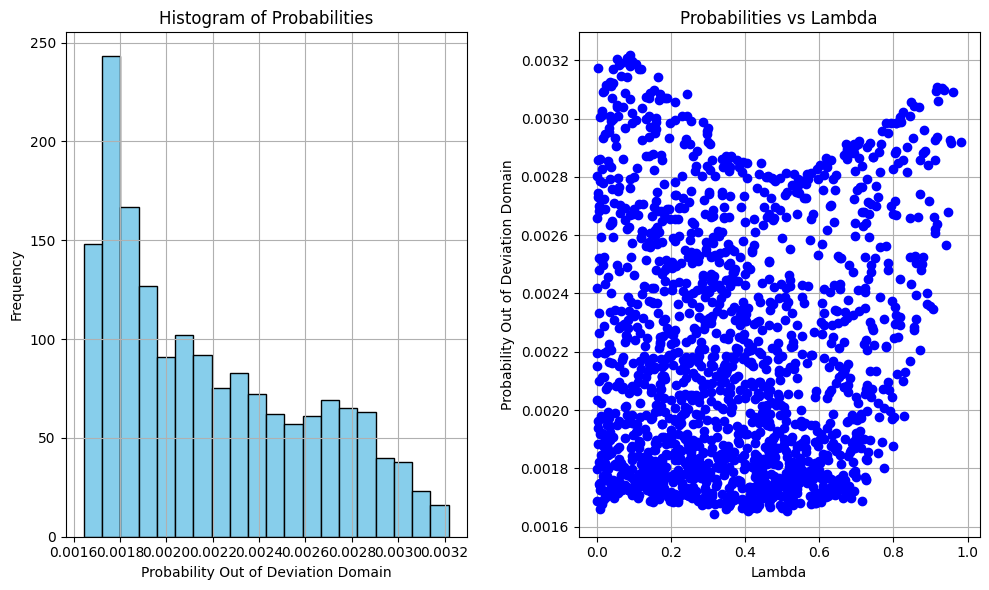

In [34]:
plt.figure(figsize=(10, 6))

# First subplot: Histogram of probabilities_out_dd
plt.subplot(1, 2, 1)
plt.hist(probabilities_out_dd, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Probability Out of Deviation Domain')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities')
plt.grid(True)

# Second subplot: Line plot of probabilities_out_dd vs lambda_sample
plt.subplot(1, 2, 2)
plt.plot(lambda_sample[:,3], probabilities_out_dd, color='blue', marker='o', linestyle='')
plt.xlabel('Lambda')
plt.ylabel('Probability Out of Deviation Domain')
plt.title('Probabilities vs Lambda')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

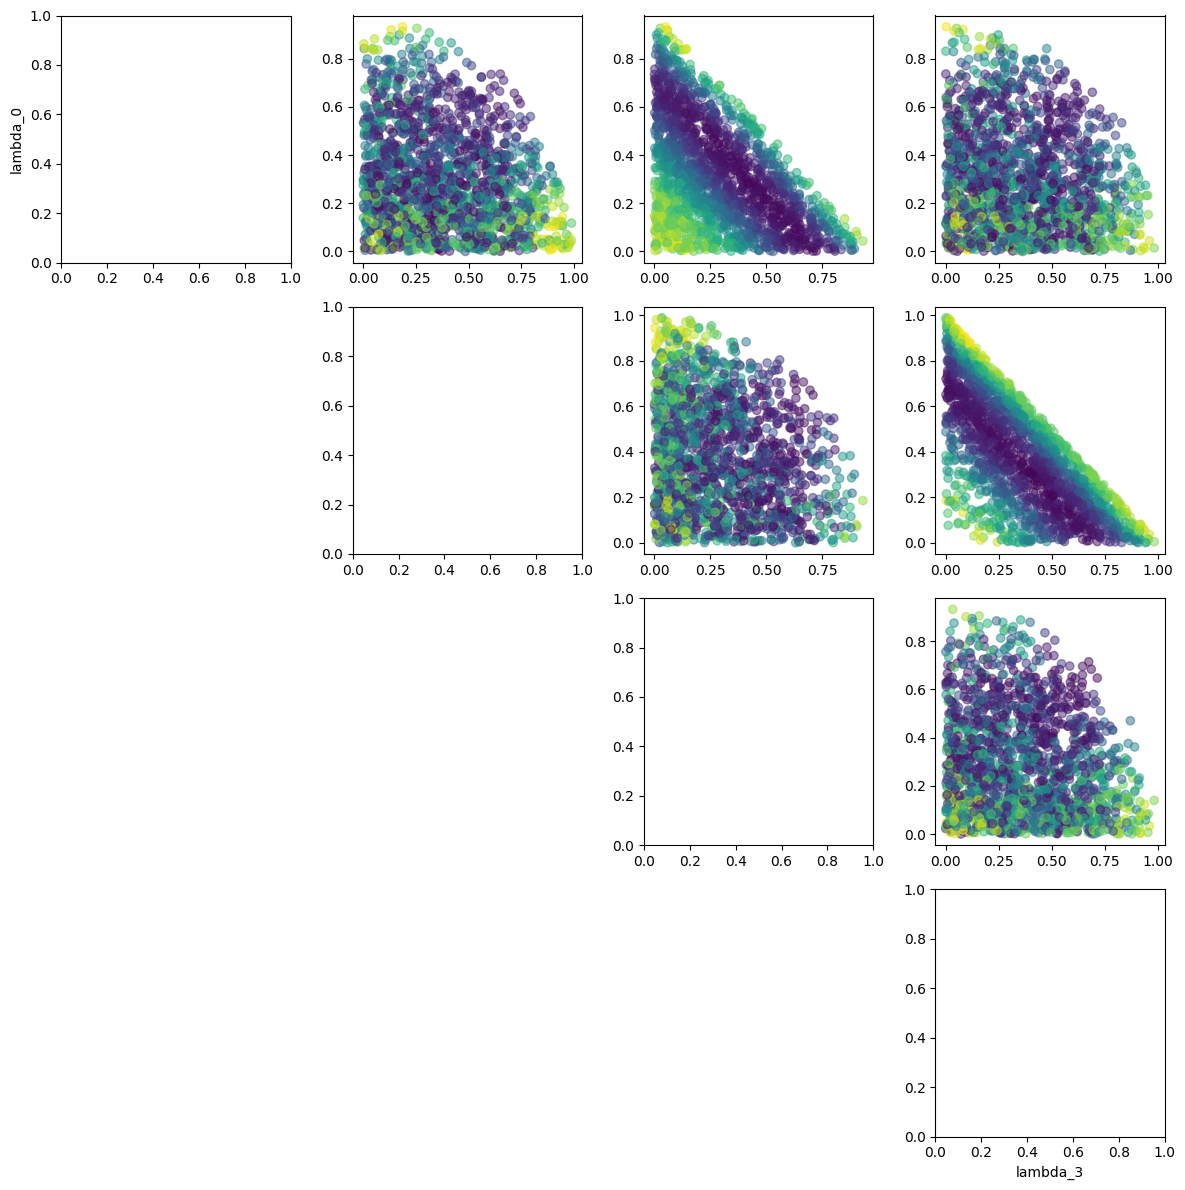

In [35]:
otaf.plotting.pair_plot(lambda_sample, labels=[f"lambda_{i}" for i in range(4)], plot_half='upper', color_by=probabilities_out_dd, hide_diag=True)

In [36]:
print(min(probabilities_out_dd))
print(max(probabilities_out_dd))

0.0016439999999999788
0.0032170000000000254
